In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import pickle

In [45]:
def mapear_a_puntaje(valor):
    if valor == -1:
        return 0  # Descalificado
    elif valor == 0:
        return 62.5  # Calidad Media (promedio de 50-74)
    elif valor == 1:
        return 87.5  # Calidad Alta (promedio de 75-100)

In [46]:
df = pd.read_csv('Datos_Train_Calidad_Lead_Clean.csv')
df.head()

,pctcuota_inicial__c,Presupuesto_inmueble_a_comprar__c,de_ingresos_sobre_el_inmueble__c,picklist_ciudad__c,Calidad_de_lead__c
0,2.330000,3.000000e+08,1.71,1,-1
1,1.000000,2.000000e+08,1.41,1,-1
2,4405.569989,2.487111e+08,-20.00,1,-1
3,0.000000,1.800000e+07,10.00,1,-1
4,0.000000,1.700000e+08,1.76,1,-1


In [47]:
# Mapear la columna 'Calidad_de_lead__c' a 'Calidad_de_lead_score'
df['Puntaje_de_calidad'] = df['Calidad_de_lead__c'].apply(mapear_a_puntaje)

In [48]:
# Separar las columnas de entrada y la salida
X = df.drop(['Calidad_de_lead__c', 'Puntaje_de_calidad'], axis=1)
y = df['Puntaje_de_calidad']    

In [49]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [50]:
# Normalizar los datos
escalador = StandardScaler()
X_train = escalador.fit_transform(X_train)
X_test = escalador.transform(X_test)

In [51]:
# Definir los modelos
modelos = {
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
    'LinearRegression': LinearRegression(),
    'SVR': SVR()
}

In [52]:
# Definir los hiperparámetros a probar
parametros_grid = {
    'RandomForestRegressor': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    'GradientBoostingRegressor': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'LinearRegression': {},
    'SVR': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
}

In [53]:
# Realizar Grid Search
mejores_modelos = []

for nombre_modelo, modelo in modelos.items():
    grid_search = GridSearchCV(estimator=modelo, param_grid=parametros_grid[nombre_modelo], scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train, y_train)
    mejores_modelos.append((nombre_modelo, grid_search.best_estimator_, grid_search.best_params_))
    print(f"Mejores parámetros para {nombre_modelo}: {grid_search.best_params_}")
    print(f"Mejor puntaje para {nombre_modelo}: {grid_search.best_score_}")

Mejores parámetros para RandomForestRegressor: {'max_depth': None, 'n_estimators': 100}
Mejor puntaje para RandomForestRegressor: -58.99993590239126
Mejores parámetros para GradientBoostingRegressor: {'learning_rate': 0.2, 'n_estimators': 200}
Mejor puntaje para GradientBoostingRegressor: -96.86930322888486
Mejores parámetros para LinearRegression: {}
Mejor puntaje para LinearRegression: -2670.537881132911
Mejores parámetros para SVR: {'C': 10, 'kernel': 'rbf'}
Mejor puntaje para SVR: -1554.418699586762


In [54]:
# Seleccionar el mejor modelo basado en los resultados del Grid Search
mejor_modelo = RandomForestRegressor(n_estimators=100, max_depth=None)
mejor_modelo.fit(X_train, y_train)

RandomForestRegressor()

In [55]:
# Predecir los valores
y_pred = mejor_modelo.predict(X_test)

In [56]:
# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred)
print(f"Error cuadrático medio del mejor modelo: {mse}")

Error cuadrático medio del mejor modelo: 11.07760908018868


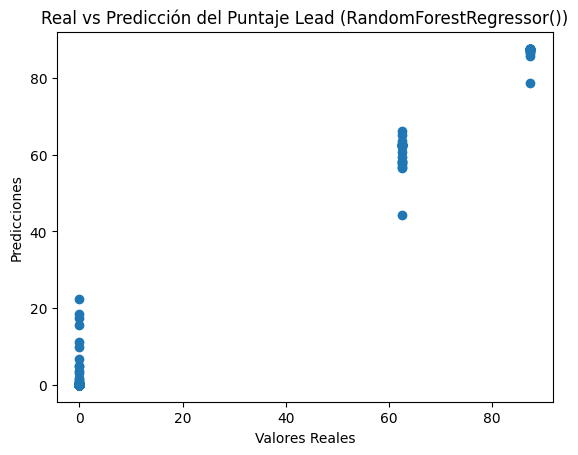

In [57]:
# Visualización de los resultados
plt.scatter(y_test, y_pred)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title(f'Real vs Predicción del Puntaje Lead ({mejor_modelo})')
plt.show()

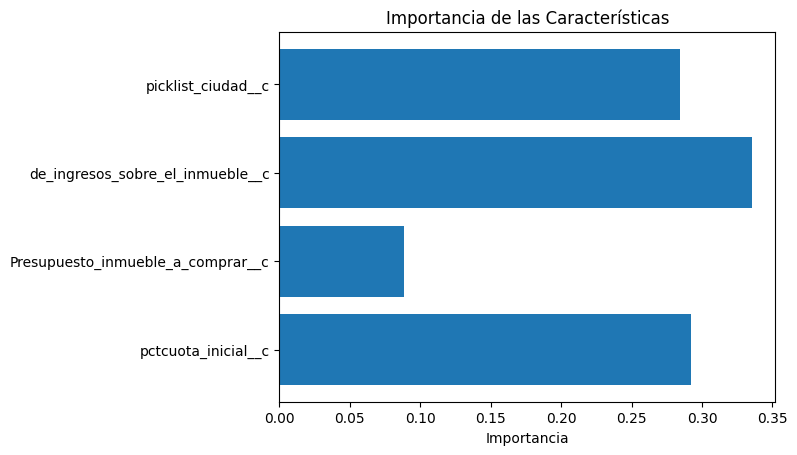

In [58]:
# Visualización de la importancia de las características
if hasattr(mejor_modelo, 'feature_importances_'):
    importancias = mejor_modelo.feature_importances_
    nombres_caracteristicas = X.columns
    plt.barh(nombres_caracteristicas, importancias)
    plt.xlabel('Importancia')
    plt.title('Importancia de las Características')
    plt.show()

In [59]:
# Aplicar la puntuación basada en la importancia de cada característica
puntajes_importancia = X_test.dot(importancias)

In [60]:
# Escalar las puntuaciones entre 0 y 100
escalador_minmax = MinMaxScaler(feature_range=(0, 100))
puntajes_importancia_escalados = escalador_minmax.fit_transform(puntajes_importancia.reshape(-1, 1))

In [61]:
# Guardar el modelo
with open('mejor_modelo_calidad_lead.pkl', 'wb') as file:
    pickle.dump(mejor_modelo, file)

In [62]:
# Mostrar los primeros 10 puntajes
print(puntajes_importancia_escalados[:10])

[[95.83184169]
 [97.78324778]
 [95.21173344]
 [76.21868179]
 [96.60411061]
 [96.89387599]
 [96.18640614]
 [96.89540486]
 [99.55618002]
 [95.78489014]]
